In [30]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from numpy import set_printoptions
set_printoptions(precision=3)
import pandas as pd
from pandas import DataFrame as df
from IPython.display import display
from collections import Counter
from scipy import sparse # stack sparse features 
from pickle import dump,load

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.preprocessing import Imputer,LabelEncoder,OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,ShuffleSplit,StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report,make_scorer,fbeta_score,roc_auc_score
from sklearn.pipeline import Pipeline

import gini_metric as gm
import encoding as enc
import feature_engineering as fe
from stacking import Stacking
import greedy_feature_selection as gfs

In [2]:
# *load data*
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv') 

# data shape
print('Train Shape: {}'.format(train_data.shape))
print('Test Shape: {}'.format(test_data.shape))

Train Shape: (595212, 59)
Test Shape: (892816, 58)


In [3]:
# *split data into X and y*
y=train_data['target']
X=train_data.drop(['target','id'],axis=1)
test_id=test_data['id']
X_test=test_data.drop(['id'],axis=1)

display(X.head())

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,2,2,5,1,0,0,1,0,0,0,...,9,1,5,8,0,1,1,0,0,1
1,1,1,7,0,0,0,0,1,0,0,...,3,1,1,9,0,1,1,0,1,0
2,5,4,9,1,0,0,0,1,0,0,...,4,2,7,7,0,1,1,0,1,0
3,0,1,2,0,0,1,0,0,0,0,...,2,2,4,9,0,0,0,0,0,0
4,0,2,0,1,0,1,0,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [4]:
# *set global parameter value*
n_jobs=-1
random_state=2018
test_size=0.2
scoring='roc_auc'
eval_metric='auc'

## Make Hold-out Validation Set

In [5]:
# *generate hold-out validation set (make sure to stratify)*
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.1,stratify=y,random_state=0)

# data shape
print('Train Shape: {}'.format(X_train.shape))
print('Hold-out Shape: {}'.format(X_val.shape))

Train Shape: (535690, 57)
Hold-out Shape: (59522, 57)


## Data Pre-processing
Separate out the numerical variables first. These variables don’t need any kind of processing and thus
we can start applying normalization and machine learning models to these variables. Pre-process categorical features.

### Split Features by Data Type - Numerical, Categorical, and Text

In [47]:
# *split attributes by data type into Numerical, Categorical and Text*
# column names split by Binary, Categorical, Ordinal vs. Continuous
bin_col=[col for col in X_train.columns if '_bin' in col]
cat_col=[col for col in X_train.columns if '_cat' in col]
numer_col=[col for col in X_train.columns if '_cat' not in col and '_bin' not in col]

# dataframes by Binary, Categorical, Ordinal vs. Continuous
def split_data(df):
    df_cat=pd.concat([df[bin_col],df[cat_col]],axis=1)
    df_numer=df[numer_col]
    return df_cat,df_numer

X_train_cat,X_train_numer=split_data(X_train)
X_val_cat,X_val_numer=split_data(X_val)
X_test_cat,X_test_numer=split_data(X_test)

### Encode Categorical Features - LabelEncoder and OneHotEncoder

In [48]:
# one hot encoding pipeline
def one_hot_encode(df):
    df_copy=df.copy()
    unique_list={col:list(X_cat[col].unique()) for col in X_cat.columns}
    for col in unique_list:
        if len(unique_list[col])>2 and len(unique_list[col])<=7:
            for val in unique_list[col]:
                df_copy[col+'_ohe_'+str(val)]=(df[col].values==val).astype(np.int)
            df_copy=df_copy.drop(col,axis=1)
    return df_copy

# call one-hot encoding
X_train_ohe=one_hot_encode(X_train_cat)
X_val_ohe=one_hot_encode(X_val_cat)
X_test_ohe=one_hot_encode(X_test_cat)

print(X_train_ohe.shape)
display(X_train_ohe.transpose())

(535690, 52)


,401794,295728,217409,65197,83255,244669,351598,64239,529525,134311,...,127819,508321,190419,413367,124196,541237,219156,575017,232792,570385
ps_ind_06_bin,1,1,0,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,1
ps_ind_07_bin,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
ps_ind_08_bin,0,0,1,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
ps_ind_09_bin,0,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,1,1,0,0,0
ps_ind_10_bin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ps_ind_11_bin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ps_ind_12_bin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ps_ind_13_bin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ps_ind_16_bin,1,0,1,1,1,0,1,1,0,0,...,1,0,0,1,1,0,1,0,1,1
ps_ind_17_bin,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### Feature Scaling of Numerical Data
After evaluating further performance of the models, we move to scaling of the datasets, so that we can evaluate linear models too.

In [45]:
std_scaler=StandardScaler()
std_scaler.fit(X_train_numer)

print(std_scaler.mean_)
print(std_scaler.scale_)

# save model using pickle
filename='standard_scaler.sav'
dump(std_scaler,open(filename,'wb'))

# load model usimg pickle
std_scaler=load(open(filename,'rb'))

X_train_scaled=df(std_scaler.transform(X_train_numer),index=X_train_numer.index,columns=X_train_numer.columns)
X_val_scaled=df(std_scaler.transform(X_val_numer),index=X_val_numer.index,columns=X_val_numer.columns)
X_test_scaled=df(std_scaler.transform(X_test_numer),index=X_test_numer.index,columns=X_test_numer.columns)

display(X_train_numer.sort_index().head())
display(X_train_scaled.sort_index().head())
print(X_train_scaled.shape)

[ 1.901  4.423  0.012  7.302  0.611  0.439  0.551  2.346  0.38   0.813
  0.276  3.066  0.45   0.45   0.45   2.372  1.886  7.69   3.006  9.227
  2.34   8.433  5.442  1.442  2.872  7.538]
[ 1.984  2.699  0.127  3.546  0.288  0.404  0.793  0.833  0.058  0.224
  0.357  0.731  0.287  0.287  0.287  1.117  1.135  1.334  1.415  1.46
  1.248  2.905  2.332  1.203  1.694  2.746]


,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,...,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
0,2,5,0,11,0.7,0.2,0.718070,2,0.400000,0.883679,...,1,10,1,10,1,5,9,1,5,8
2,5,9,0,12,0.0,0.0,-1.000000,1,0.316228,0.641586,...,2,9,1,8,2,7,4,2,7,7
3,0,2,0,8,0.9,0.2,0.580948,1,0.374166,0.542949,...,4,7,1,8,4,2,2,2,4,9
5,5,4,0,6,0.9,1.8,2.332649,2,0.445982,0.879049,...,1,8,2,11,3,8,4,2,0,9
6,2,3,0,8,0.6,0.1,0.617454,2,0.316228,0.639683,...,2,8,1,8,3,10,3,0,0,10


,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,...,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
0,0.049902,0.213895,-0.097539,1.042940,0.309412,-0.591134,0.210367,-0.415499,0.343606,0.313717,...,-0.780423,1.731050,-1.418024,0.529711,-1.073578,-1.181914,1.525376,-0.367591,1.256117,0.168303
2,1.561959,1.696153,-0.097539,1.324938,-2.124071,-1.085776,-1.955512,-1.616548,-1.092398,-0.764747,...,0.100728,0.981636,-1.418024,-0.840396,-0.272250,-0.493411,-0.618505,0.463343,2.436422,-0.195898
3,-0.958136,-0.897799,-0.097539,0.196946,1.004693,-0.591134,0.037503,-1.616548,-0.099239,-1.204150,...,1.863030,-0.517192,-1.418024,-0.840396,1.330406,-2.214668,-1.476058,0.463343,0.665964,0.532505
5,1.561959,-0.156670,-0.097539,-0.367049,1.004693,3.366002,2.245779,-0.415499,1.131820,0.293093,...,-0.780423,0.232222,-0.711070,1.214765,0.529078,-0.149160,-0.618505,0.463343,-1.694647,0.532505
6,0.049902,-0.527235,-0.097539,0.196946,-0.038228,-0.838455,0.083526,-0.415499,-1.092398,-0.773224,...,0.100728,0.232222,-1.418024,-0.840396,0.529078,0.539343,-1.047281,-1.198524,-1.694647,0.896707


(535690, 26)


### Stack Features

In [50]:
# stack dataframes
def stacking(cat_df,numer_df):
    return pd.concat([cat_df,numer_df],axis=1)

X_train_stacked=stacking(X_train_ohe,X_train_scaled)
X_val_stacked=stacking(X_val_ohe,X_val_scaled)
X_test_stacked=stacking(X_test_ohe,X_test_scaled)

display(X_train_stacked.sort_index().transpose())

,0,2,3,5,6,7,8,9,10,11,...,595200,595203,595204,595205,595206,595207,595208,595209,595210,595211
ps_ind_06_bin,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
ps_ind_07_bin,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ps_ind_08_bin,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
ps_ind_09_bin,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
ps_ind_10_bin,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ps_ind_11_bin,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ps_ind_12_bin,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ps_ind_13_bin,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ps_ind_16_bin,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
ps_ind_17_bin,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Feature Selection

In [54]:
# duplicate rows removal pipeline
def duplicates_removal(base,df):
    dups=base[base.duplicated(keep=False)]
    df_no_dups=df[~(df.index.isin(dups.index))]
    return df_no_dups    

#### 1) Manual Filtering

In [57]:
# feature selection pipeline
def feature_selection(df):
    # drop '_calc_' attributes (20 '_calc_' columns in total)
    cols=[col for col in df.columns if col.startswith('ps_calc_')]
    df_selected=df.drop(cols,axis=1)
    return df_selected

# call feature selection
X_train_filter=feature_selection(X_train_stacked)
X_val_filter=feature_selection(X_val_stacked)
X_test_filter=feature_selection(X_test_stacked)

print(X_train_filter.shape)

# remove duplicate rows from X_train and y_train
X_train_filter_nd=duplicates_removal(X_train_filter,X_train_filter)
y_train_filter_nd=duplicates_removal(X_train_filter,df(y_train))
#X_val_filter_nd=duplicates_removal(X_val_filter,X_val_filter)
#y_val_filter_nd=duplicates_removal(X_val_filter,df(y_val))

print(X_train_filter_nd.shape)
print(y_train_filter_nd.shape)

NameError: name 'X_test_stacked' is not defined

#### 2) Wrapper Methods - Greedy Feature Selection
One of the most common way is greedy feature selection (forward or backward). In greedy feature selection we choose one feature, train a model and evaluate the performance of the model on a fixed evaluation metric. We keep adding and removing features one-by-one and record performance of the model at every step. We then select the features which have the best evaluation score. One implementation of greedy feature selection with AUC as evaluation metric can be found here: https://github.com/abhishekkrthakur/greedyFeatureSelection

In [55]:
greedy=gfs.greedyFeatureSelection(np.array(X_train_filter_nd),y_train_nd,scale=0,verbose=True)
greedy.selectionLoop(np.array(X_train_filter_nd),y_train_nd);

Current AUC :  0.545076888225
Current AUC :  0.540735296406
Current AUC :  0.513041978521
Current AUC :  0.508700386702
Current AUC :  0.500131978807
Current AUC :  0.500233796235
Current AUC :  0.501782085814
Current AUC :  0.500224541756
Current AUC :  0.535434644222
Current AUC :  0.532352172188
Current AUC :  0.504538530497
Current AUC :  0.520557626051
Current AUC :  0.528928871897
Current AUC :  0.536200790413
Current AUC :  0.515797901044
Current AUC :  0.520917865979
Current AUC :  0.51261666391
Current AUC :  0.504458782174
Current AUC :  0.507114690813
Current AUC :  0.501350063862
Current AUC :  0.500512316844
Current AUC :  0.500793527932
Current AUC :  0.513982838936
Current AUC :  0.514735079395
Current AUC :  0.500752240459
Current AUC :  0.531710048726
Current AUC :  0.531713923538
Current AUC :  0.500003874813
Current AUC :  0.531484586891
Current AUC :  0.505695535653
Current AUC :  0.537180122544
Current AUC :  0.516917208049
Current AUC :  0.531106685992
Current AUC

Current AUC :  0.606258779758
Current AUC :  0.605919512273
Current AUC :  0.606234202364
Current AUC :  0.609223876666
Current AUC :  0.607616596768
Current AUC :  0.608404997083
Current AUC :  0.606141560724
Current AUC :  0.605847699139
Current AUC :  0.606154226354
Current AUC :  0.605943789589
Current Features :  [9, 11, 34, 51, 55]
Current AUC :  0.614810884028
Current AUC :  0.614952417838
Current AUC :  0.613451837483
Current AUC :  0.612904349779
Current AUC :  0.613115517537
Current AUC :  0.613108013114
Current AUC :  0.613219400777
Current AUC :  0.613095869147
Current AUC :  0.613731737319
Current AUC :  0.613968469731
Current AUC :  0.613320075201
Current AUC :  0.613094824829
Current AUC :  0.61312870994
Current AUC :  0.613087964571
Current AUC :  0.613039200659
Current AUC :  0.613597471115
Current AUC :  0.613753492355
Current AUC :  0.613228791452
Current AUC :  0.613104289035
Current AUC :  0.613274187827
Current AUC :  0.614304539215
Current AUC :  0.61430830785
Cu

Current AUC :  0.622695768061
Current AUC :  0.622697539353
Current AUC :  0.622690425061
Current AUC :  0.622708627392
Current AUC :  0.622683833375
Current AUC :  0.622698170667
Current AUC :  0.62285100914
Current AUC :  0.622742222001
Current AUC :  0.622700554022
Current AUC :  0.622893414065
Current AUC :  0.622742186575
Current AUC :  0.622778613862
Current AUC :  0.622556624205
Current AUC :  0.623182698076
Current AUC :  0.62323070857
Current AUC :  0.622805550696
Current AUC :  0.622720761039
Current AUC :  0.622903333548
Current AUC :  0.62299969495
Current AUC :  0.62305007049
Current AUC :  0.622856391337
Current AUC :  0.622727821646
Current AUC :  0.622726253383
Current AUC :  0.622694111333
Current AUC :  0.622903206779
Current AUC :  0.622902105601
Current AUC :  0.622697916187
Current AUC :  0.622671275114
Current AUC :  0.622733742971
Current AUC :  0.62261159533
Current AUC :  0.622620191206
Current AUC :  0.622626478548
Current AUC :  0.623482389741
Current AUC :  

Current AUC :  0.625268332308
Current AUC :  0.62527715602
Current AUC :  0.625287364913
Current AUC :  0.625326121721
Current AUC :  0.625288471251
Current AUC :  0.625592768622
Current AUC :  0.625320056709
Current AUC :  0.625239004875
Current AUC :  0.625289476521
Current AUC :  0.625464090571
Current Features :  [0, 3, 9, 11, 18, 20, 23, 30, 34, 38, 47, 49, 50, 51, 52, 55]
Current AUC :  0.625603538176
Current AUC :  0.625603625401
Current AUC :  0.625586997684
Current AUC :  0.625607923736
Current AUC :  0.625579372595
Current AUC :  0.625597722286
Current AUC :  0.62567065168
Current AUC :  0.625601693254
Current AUC :  0.625604232255
Current AUC :  0.625759645749
Current AUC :  0.625604779767
Current AUC :  0.625643445133
Current AUC :  0.625504468533
Current AUC :  0.625574255695
Current AUC :  0.625638146143
Current AUC :  0.625747364593
Current AUC :  0.625694410906
Current AUC :  0.625691659598
Current AUC :  0.625606122278
Current AUC :  0.625604349596
Current AUC :  0.625

Current AUC :  0.626506307779
Current AUC :  0.626428737501
Current AUC :  0.62640947299
Current AUC :  0.626413846345
Current AUC :  0.626402165047
Current AUC :  0.626332435489
Current AUC :  0.626444632389
Current AUC :  0.626449441372
Current AUC :  0.626378779529
Current AUC :  0.626381741109
Current AUC :  0.626437126379
Current AUC :  0.626436623967
Current AUC :  0.626413878992
Current AUC :  0.6264126117
Current AUC :  0.626492039999
Current AUC :  0.626501988705
Current AUC :  0.626419394309
Current AUC :  0.626374624684
Current AUC :  0.626379466413
Current AUC :  0.626418372417
Current AUC :  0.626416756225
Current AUC :  0.626413580006
Current AUC :  0.626386924594
Current AUC :  0.626396809891
Current AUC :  0.626413373206
Current AUC :  0.626454755446
Current AUC :  0.626411497324
Current AUC :  0.626412471584
Current AUC :  0.626414846207
Current AUC :  0.626388382313
Current Features :  [0, 3, 8, 9, 11, 13, 18, 20, 21, 23, 28, 30, 34, 38, 39, 40, 47, 49, 50, 51, 52, 53

Current AUC :  0.627002099909
Current AUC :  0.627000927582
Current AUC :  0.626995179864
Current AUC :  0.62693653383
Current AUC :  0.626952947801
Current AUC :  0.626976725484
Current AUC :  0.626981235084
Current AUC :  0.626975905133
Current Features :  [0, 3, 8, 9, 11, 12, 13, 18, 20, 21, 23, 26, 28, 30, 32, 33, 34, 38, 39, 40, 46, 47, 49, 50, 51, 52, 53, 54, 55, 57]
Current AUC :  0.627009539335
Current AUC :  0.626997654017
Current AUC :  0.627016776625
Current AUC :  0.627021449363
Current AUC :  0.627004107274
Current AUC :  0.627013365028
Current AUC :  0.627018745687
Current AUC :  0.627035303643
Current AUC :  0.627047952354
Current AUC :  0.626982179971
Current AUC :  0.627033766142
Current AUC :  0.627039267169
Current AUC :  0.626990255971
Current AUC :  0.626987583553
Current AUC :  0.627003417612
Current AUC :  0.627019485362
Current AUC :  0.627005724161
Current AUC :  0.627006256739
Current AUC :  0.627006581526
Current AUC :  0.627002882255
Current AUC :  0.6270381

In [56]:
ind=[0, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36]
features_ind=[X_train_filter_nd.columns[i] for i in ind]
display(features_ind)

['ps_ind_06_bin',
 'ps_ind_09_bin',
 'ps_ind_11_bin',
 'ps_ind_13_bin',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_04_cat',
 'ps_car_06_cat',
 'ps_car_08_cat',
 'ps_car_11_cat',
 'ps_ind_02_cat_ohe_2',
 'ps_ind_02_cat_ohe_1',
 'ps_ind_02_cat_ohe_4',
 'ps_ind_02_cat_ohe_3',
 'ps_ind_02_cat_ohe_-1',
 'ps_ind_04_cat_ohe_1',
 'ps_car_02_cat_ohe_1',
 'ps_car_02_cat_ohe_0',
 'ps_car_03_cat_ohe_1',
 'ps_car_03_cat_ohe_0',
 'ps_car_03_cat_ohe_-1',
 'ps_car_05_cat_ohe_1',
 'ps_car_05_cat_ohe_-1',
 'ps_car_05_cat_ohe_0',
 'ps_car_07_cat_ohe_1',
 'ps_car_07_cat_ohe_-1',
 'ps_car_07_cat_ohe_0']

In [23]:
X_train_gsel=X_train_filter_nd[features_ind]
X_val_gsel=X_vail_filter_nd[features_ind]
X_test_gsel=X_test_filter_nd[features_ind]

display(X_train_gsel.transpose())

# remove duplicate rows from X_train and y_train
X_train_gsel_nd=duplicates_removal(X_train_gsel,X_train_gsel)
y_train_gsel_nd=duplicates_removal(X_train_gsel,df(y_train_filter_nd))

print(X_train_gsel_nd.shape)

,401794,295728,217409,65197,83255,244669,351598,64239,529525,134311,...,127819,508321,190419,413367,124196,541237,219156,575017,232792,570385
ps_ind_06_bin,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
ps_ind_09_bin,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
ps_ind_11_bin,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ps_ind_13_bin,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ps_ind_16_bin,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
ps_ind_17_bin,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
ps_ind_18_bin,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
ps_ind_02_cat,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
ps_ind_04_cat,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ps_ind_05_cat,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


(535676, 30)


#### 3) Embedded Methods
Other faster methods of feature selection include selecting best features from a model. We can either look at coeficients of a logit model or we can train a random forest to select best features and then use them later with other machine learning models. Remember to keep low number of estimators and minimal optimization of hyper parameters so that you don’t overfit. The feature selection can also be achieved using Gradient Boosting Machines.

#### 3) SelectKBest with chi2

#### Feature Union

### Adding Polynomial and Interaction Features

In [ ]:
# polynomial (non-linear relationships) and interaction features (effect of one feature depends on another) pipeline
def feature_interaction(base,df):
    df_copy=df.copy()
    # construct feature interactions
    df_copy['ps_car_13_x_reg_03']=df['ps_car_13']*df['ps_reg_03']
    df_copy['neg_one_row_sum']=np.sum((df[df.columns]==-1).values,axis=1)
    #df_copy['ps_reg_01_x_02_x_03']=df['ps_reg_01']*df['ps_reg_02']*df['ps_reg_03']
    #df_copy['ps_ind_bins_sum']=df['ps_ind_06_bin']+df['ps_ind_07_bin']+df['ps_ind_08_bin']+df['ps_ind_09_bin'] \
    #+df['ps_ind_10_bin']+df['ps_ind_11_bin']+df['ps_ind_12_bin']+df['ps_ind_13_bin']+df['ps_ind_16_bin'] \
    #+df['ps_ind_17_bin']+df['ps_ind_18_bin']
    # binarize feature data
    base_nan=base.replace(-1,np.NaN)
    col_median=base_nan.median(axis=0)
    col_mean=base_nan.mean(axis=0)
    for col in base.columns:
        if '_bin' not in col:
            df_copy[col+str('_median_range')] = (df[col].values>col_median[col]).astype(np.int)
            df_copy[col+str('_mean_range')] = (df[col].values>col_mean[col]).astype(np.int)
    return df_copy

# feature engineering
X_eng=feature_interaction(X_sel,X_no_dups)
X_test_eng=feature_interaction(X_sel,X_test_sel)

# check feature engineering results
#print(X_ohe.shape)
#with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    #display(X_ohe.transpose())

## Spot-Check Tree-based Algorithms
At this stage only models you should go for should be ensemble tree based models. These models include:
* RandomForestClassifier
* ExtraTreesClassifier
* XGBClassifier
* LightGBM

We cannot apply linear models to the above features since they are not normalized. To use linear models, one can use Normalizer or StandardScaler from scikit-learn.
### 1) XGBoost

[0]	validation_0-auc:0.594468	validation_1-auc:0.592479
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100.0 rounds.
[1]	validation_0-auc:0.614698	validation_1-auc:0.610944
[2]	validation_0-auc:0.621393	validation_1-auc:0.617341
[3]	validation_0-auc:0.623247	validation_1-auc:0.619369
[4]	validation_0-auc:0.625717	validation_1-auc:0.620745
[5]	validation_0-auc:0.627383	validation_1-auc:0.622556
[6]	validation_0-auc:0.627733	validation_1-auc:0.623
[7]	validation_0-auc:0.6288	validation_1-auc:0.623621
[8]	validation_0-auc:0.629346	validation_1-auc:0.623642
[9]	validation_0-auc:0.629353	validation_1-auc:0.623389
[10]	validation_0-auc:0.629562	validation_1-auc:0.623992
[11]	validation_0-auc:0.630105	validation_1-auc:0.624338
[12]	validation_0-auc:0.63058	validation_1-auc:0.624586
[13]	validation_0-auc:0.630942	validation_1-auc:0.624435
[14]	validation_0-auc:0.631537	validation_1-auc:0.624993
[

[142]	validation_0-auc:0.642314	validation_1-auc:0.629885
[143]	validation_0-auc:0.642379	validation_1-auc:0.629861
[144]	validation_0-auc:0.642387	validation_1-auc:0.629872
[145]	validation_0-auc:0.64243	validation_1-auc:0.629844
[146]	validation_0-auc:0.642482	validation_1-auc:0.629846
[147]	validation_0-auc:0.642512	validation_1-auc:0.629836
[148]	validation_0-auc:0.642535	validation_1-auc:0.629831
[149]	validation_0-auc:0.642527	validation_1-auc:0.629853
[150]	validation_0-auc:0.642525	validation_1-auc:0.62986
[151]	validation_0-auc:0.64275	validation_1-auc:0.629981
[152]	validation_0-auc:0.642755	validation_1-auc:0.629986
[153]	validation_0-auc:0.642693	validation_1-auc:0.629959
[154]	validation_0-auc:0.642728	validation_1-auc:0.629969
[155]	validation_0-auc:0.6427	validation_1-auc:0.629897
[156]	validation_0-auc:0.64282	validation_1-auc:0.6299
[157]	validation_0-auc:0.642801	validation_1-auc:0.629951
[158]	validation_0-auc:0.642748	validation_1-auc:0.629916
[159]	validation_0-auc

[284]	validation_0-auc:0.652499	validation_1-auc:0.633426
[285]	validation_0-auc:0.652584	validation_1-auc:0.633444
[286]	validation_0-auc:0.652676	validation_1-auc:0.633466
[287]	validation_0-auc:0.652788	validation_1-auc:0.633515
[288]	validation_0-auc:0.652851	validation_1-auc:0.633566
[289]	validation_0-auc:0.652961	validation_1-auc:0.633608
[290]	validation_0-auc:0.653051	validation_1-auc:0.633657
[291]	validation_0-auc:0.653296	validation_1-auc:0.633755
[292]	validation_0-auc:0.653369	validation_1-auc:0.633768
[293]	validation_0-auc:0.653514	validation_1-auc:0.633759
[294]	validation_0-auc:0.653572	validation_1-auc:0.6338
[295]	validation_0-auc:0.65369	validation_1-auc:0.63382
[296]	validation_0-auc:0.653712	validation_1-auc:0.633776
[297]	validation_0-auc:0.653774	validation_1-auc:0.633807
[298]	validation_0-auc:0.653899	validation_1-auc:0.633818
[299]	validation_0-auc:0.65397	validation_1-auc:0.633857
[300]	validation_0-auc:0.654017	validation_1-auc:0.633852
[301]	validation_0-

[426]	validation_0-auc:0.667322	validation_1-auc:0.637986
[427]	validation_0-auc:0.667446	validation_1-auc:0.638018
[428]	validation_0-auc:0.667586	validation_1-auc:0.638078
[429]	validation_0-auc:0.667725	validation_1-auc:0.638089
[430]	validation_0-auc:0.667864	validation_1-auc:0.638201
[431]	validation_0-auc:0.668012	validation_1-auc:0.638246
[432]	validation_0-auc:0.668099	validation_1-auc:0.63825
[433]	validation_0-auc:0.668265	validation_1-auc:0.638298
[434]	validation_0-auc:0.668418	validation_1-auc:0.638363
[435]	validation_0-auc:0.668515	validation_1-auc:0.638354
[436]	validation_0-auc:0.668656	validation_1-auc:0.638411
[437]	validation_0-auc:0.668795	validation_1-auc:0.638459
[438]	validation_0-auc:0.668924	validation_1-auc:0.638479
[439]	validation_0-auc:0.669063	validation_1-auc:0.638522
[440]	validation_0-auc:0.669196	validation_1-auc:0.638523
[441]	validation_0-auc:0.669343	validation_1-auc:0.638571
[442]	validation_0-auc:0.669458	validation_1-auc:0.638636
[443]	validatio

[568]	validation_0-auc:0.681365	validation_1-auc:0.642034
[569]	validation_0-auc:0.681395	validation_1-auc:0.642035
[570]	validation_0-auc:0.68144	validation_1-auc:0.64203
[571]	validation_0-auc:0.681539	validation_1-auc:0.642051
[572]	validation_0-auc:0.681615	validation_1-auc:0.642078
[573]	validation_0-auc:0.681732	validation_1-auc:0.642132
[574]	validation_0-auc:0.681867	validation_1-auc:0.642173
[575]	validation_0-auc:0.681915	validation_1-auc:0.642201
[576]	validation_0-auc:0.68201	validation_1-auc:0.642236
[577]	validation_0-auc:0.682116	validation_1-auc:0.642233
[578]	validation_0-auc:0.68222	validation_1-auc:0.642269
[579]	validation_0-auc:0.682281	validation_1-auc:0.642305
[580]	validation_0-auc:0.682372	validation_1-auc:0.642328
[581]	validation_0-auc:0.682439	validation_1-auc:0.642376
[582]	validation_0-auc:0.682552	validation_1-auc:0.642387
[583]	validation_0-auc:0.682654	validation_1-auc:0.642405
[584]	validation_0-auc:0.682775	validation_1-auc:0.642388
[585]	validation_0

[710]	validation_0-auc:0.693259	validation_1-auc:0.644504
[711]	validation_0-auc:0.693357	validation_1-auc:0.644499
[712]	validation_0-auc:0.693465	validation_1-auc:0.644498
[713]	validation_0-auc:0.693513	validation_1-auc:0.64451
[714]	validation_0-auc:0.693591	validation_1-auc:0.644487
[715]	validation_0-auc:0.693689	validation_1-auc:0.644471
[716]	validation_0-auc:0.693759	validation_1-auc:0.644463
[717]	validation_0-auc:0.693834	validation_1-auc:0.644477
[718]	validation_0-auc:0.693876	validation_1-auc:0.644485
[719]	validation_0-auc:0.693905	validation_1-auc:0.644482
[720]	validation_0-auc:0.69398	validation_1-auc:0.644512
[721]	validation_0-auc:0.69408	validation_1-auc:0.644543
[722]	validation_0-auc:0.694159	validation_1-auc:0.644544
[723]	validation_0-auc:0.694263	validation_1-auc:0.644562
[724]	validation_0-auc:0.694337	validation_1-auc:0.644563
[725]	validation_0-auc:0.694389	validation_1-auc:0.644566
[726]	validation_0-auc:0.694472	validation_1-auc:0.644568
[727]	validation_

[852]	validation_0-auc:0.703268	validation_1-auc:0.645537
[853]	validation_0-auc:0.70331	validation_1-auc:0.645547
[854]	validation_0-auc:0.703357	validation_1-auc:0.645559
[855]	validation_0-auc:0.703401	validation_1-auc:0.645558
[856]	validation_0-auc:0.703452	validation_1-auc:0.645563
[857]	validation_0-auc:0.703509	validation_1-auc:0.64559
[858]	validation_0-auc:0.703556	validation_1-auc:0.645584
[859]	validation_0-auc:0.703618	validation_1-auc:0.645591
[860]	validation_0-auc:0.703675	validation_1-auc:0.645602
[861]	validation_0-auc:0.703714	validation_1-auc:0.645604
[862]	validation_0-auc:0.70374	validation_1-auc:0.645594
[863]	validation_0-auc:0.703815	validation_1-auc:0.645601
[864]	validation_0-auc:0.703907	validation_1-auc:0.645611
[865]	validation_0-auc:0.704028	validation_1-auc:0.645634
[866]	validation_0-auc:0.70408	validation_1-auc:0.645648
[867]	validation_0-auc:0.704142	validation_1-auc:0.64566
[868]	validation_0-auc:0.704228	validation_1-auc:0.645674
[869]	validation_0-

[994]	validation_0-auc:0.712054	validation_1-auc:0.646036
[995]	validation_0-auc:0.712137	validation_1-auc:0.646022
[996]	validation_0-auc:0.712181	validation_1-auc:0.646016
[997]	validation_0-auc:0.712238	validation_1-auc:0.646017
[998]	validation_0-auc:0.712309	validation_1-auc:0.64602
[999]	validation_0-auc:0.712339	validation_1-auc:0.646024


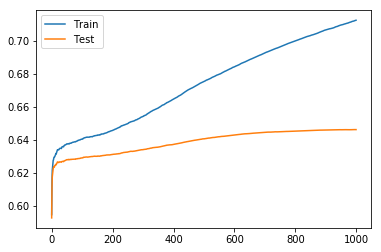

0.646023848826


In [24]:
# sklearn API
# initialize model
max_depth=6 # max leaf nodes 2^3 = 8 recommended by Friedman; start with 6 and grid search [4,6,8,10] by Owen Zhang
#max_leaf_nodes=4 # comparable config is max_depth + 1; faster training with max_leaf_nodes with slightly higher error
#min_child_weight # large enough to get a meaingful mean
n_estimators=1000 # large value with intent to use early stopping on validation set to pick final number
#n_estimators=100 # by Owen Zhang - fix @ 100 and then tune learning rate
learning_rate=0.01 # start with shrinkage < 0.1; (2 to 10) / # of iterations (Owen Zhang)
subsample=0.8 # 0.4 as recommended by Friedman; Grid Search [0.5, 0.75, 1.0] or fix at 1.0 by Owen Zhang
colsample_bytree=0.8 # grid search [0.4,0.6,0.8,1.0] or between 0.3 and 0.5 by Owen Zhang
model=XGBClassifier(max_depth=max_depth,n_estimators=n_estimators,learning_rate=learning_rate,
                    subsample=subsample,colsample_bytree=colsample_bytree,n_jobs=n_jobs,random_state=random_state)
X_train_2,X_val_2,y_train_2,y_val_2=train_test_split(X_no_dups_2,y_no_dups_2,test_size=0.3,stratify=y_no_dups_2
                                                     ,random_state=0)

# fit to train & cross validation data
early_stopping_rounds=0.1*n_estimators # generally as a % (e.g. 10%) of training epochs
eval_set=[(X_train_2,y_train_2),(X_val_2,y_val_2)]
model.fit(X_train_2,y_train_2,early_stopping_rounds=early_stopping_rounds,eval_metric=eval_metric,
          eval_set=eval_set,verbose=True)
results=model.evals_result()

# plot learning curve 
rounds=len(results['validation_0']['auc'])
x_axis=range(0,rounds)
fig,ax=plt.subplots()
ax.plot(x_axis,results['validation_0']['auc'],label='Train')
ax.plot(x_axis,results['validation_1']['auc'],label='Test')
ax.legend()
plt.show()

# predictions
predicted=model.predict_proba(X_val_2)[:,1]

# model performance reports
print(roc_auc_score(y_val_2,predicted))

### 2) LightGBM

[1]	training's auc: 0.611099	valid_1's auc: 0.609489
Training until validation scores don't improve for 100.0 rounds.
[2]	training's auc: 0.61492	valid_1's auc: 0.612649
[3]	training's auc: 0.621421	valid_1's auc: 0.617952
[4]	training's auc: 0.624037	valid_1's auc: 0.619637
[5]	training's auc: 0.626194	valid_1's auc: 0.620725
[6]	training's auc: 0.626608	valid_1's auc: 0.621061
[7]	training's auc: 0.626561	valid_1's auc: 0.6212
[8]	training's auc: 0.627357	valid_1's auc: 0.622275
[9]	training's auc: 0.627837	valid_1's auc: 0.6231
[10]	training's auc: 0.628437	valid_1's auc: 0.623572
[11]	training's auc: 0.628656	valid_1's auc: 0.623595
[12]	training's auc: 0.630016	valid_1's auc: 0.624569
[13]	training's auc: 0.629811	valid_1's auc: 0.62428
[14]	training's auc: 0.629875	valid_1's auc: 0.624321
[15]	training's auc: 0.630479	valid_1's auc: 0.624859
[16]	training's auc: 0.630535	valid_1's auc: 0.624853
[17]	training's auc: 0.630248	valid_1's auc: 0.62468
[18]	training's auc: 0.630753	val

[154]	training's auc: 0.63603	valid_1's auc: 0.62868
[155]	training's auc: 0.636121	valid_1's auc: 0.628693
[156]	training's auc: 0.63617	valid_1's auc: 0.62871
[157]	training's auc: 0.636133	valid_1's auc: 0.628723
[158]	training's auc: 0.636073	valid_1's auc: 0.628677
[159]	training's auc: 0.636103	valid_1's auc: 0.628688
[160]	training's auc: 0.636194	valid_1's auc: 0.628807
[161]	training's auc: 0.636287	valid_1's auc: 0.628861
[162]	training's auc: 0.636352	valid_1's auc: 0.628906
[163]	training's auc: 0.636418	valid_1's auc: 0.628949
[164]	training's auc: 0.636376	valid_1's auc: 0.628936
[165]	training's auc: 0.63642	valid_1's auc: 0.628955
[166]	training's auc: 0.63642	valid_1's auc: 0.628991
[167]	training's auc: 0.636387	valid_1's auc: 0.628959
[168]	training's auc: 0.636409	valid_1's auc: 0.628937
[169]	training's auc: 0.63643	valid_1's auc: 0.628894
[170]	training's auc: 0.636561	valid_1's auc: 0.628981
[171]	training's auc: 0.636625	valid_1's auc: 0.628989
[172]	training's 

[306]	training's auc: 0.644025	valid_1's auc: 0.633039
[307]	training's auc: 0.644107	valid_1's auc: 0.633055
[308]	training's auc: 0.644201	valid_1's auc: 0.633171
[309]	training's auc: 0.644291	valid_1's auc: 0.633205
[310]	training's auc: 0.644378	valid_1's auc: 0.63322
[311]	training's auc: 0.644553	valid_1's auc: 0.633272
[312]	training's auc: 0.644725	valid_1's auc: 0.633324
[313]	training's auc: 0.644786	valid_1's auc: 0.633341
[314]	training's auc: 0.64483	valid_1's auc: 0.63336
[315]	training's auc: 0.644837	valid_1's auc: 0.633353
[316]	training's auc: 0.644953	valid_1's auc: 0.633454
[317]	training's auc: 0.644972	valid_1's auc: 0.633463
[318]	training's auc: 0.644994	valid_1's auc: 0.633439
[319]	training's auc: 0.64511	valid_1's auc: 0.633528
[320]	training's auc: 0.64515	valid_1's auc: 0.633536
[321]	training's auc: 0.645313	valid_1's auc: 0.633638
[322]	training's auc: 0.645394	valid_1's auc: 0.633667
[323]	training's auc: 0.645465	valid_1's auc: 0.633728
[324]	training'

[458]	training's auc: 0.655904	valid_1's auc: 0.638316
[459]	training's auc: 0.655998	valid_1's auc: 0.638359
[460]	training's auc: 0.656071	valid_1's auc: 0.638376
[461]	training's auc: 0.65613	valid_1's auc: 0.638398
[462]	training's auc: 0.656172	valid_1's auc: 0.638395
[463]	training's auc: 0.656231	valid_1's auc: 0.638409
[464]	training's auc: 0.656283	valid_1's auc: 0.638436
[465]	training's auc: 0.65635	valid_1's auc: 0.638455
[466]	training's auc: 0.656397	valid_1's auc: 0.638473
[467]	training's auc: 0.656457	valid_1's auc: 0.638515
[468]	training's auc: 0.656534	valid_1's auc: 0.638535
[469]	training's auc: 0.656566	valid_1's auc: 0.638554
[470]	training's auc: 0.656638	valid_1's auc: 0.638613
[471]	training's auc: 0.656747	valid_1's auc: 0.638636
[472]	training's auc: 0.6568	valid_1's auc: 0.638633
[473]	training's auc: 0.656879	valid_1's auc: 0.638642
[474]	training's auc: 0.65696	valid_1's auc: 0.638664
[475]	training's auc: 0.657028	valid_1's auc: 0.638684
[476]	training'

[610]	training's auc: 0.666039	valid_1's auc: 0.642163
[611]	training's auc: 0.66609	valid_1's auc: 0.642202
[612]	training's auc: 0.666159	valid_1's auc: 0.642237
[613]	training's auc: 0.666216	valid_1's auc: 0.64226
[614]	training's auc: 0.66626	valid_1's auc: 0.642285
[615]	training's auc: 0.666338	valid_1's auc: 0.642315
[616]	training's auc: 0.666424	valid_1's auc: 0.642355
[617]	training's auc: 0.666492	valid_1's auc: 0.642376
[618]	training's auc: 0.666573	valid_1's auc: 0.642398
[619]	training's auc: 0.666658	valid_1's auc: 0.6424
[620]	training's auc: 0.666723	valid_1's auc: 0.642414
[621]	training's auc: 0.666804	valid_1's auc: 0.642421
[622]	training's auc: 0.666853	valid_1's auc: 0.642435
[623]	training's auc: 0.666907	valid_1's auc: 0.642463
[624]	training's auc: 0.666969	valid_1's auc: 0.642492
[625]	training's auc: 0.66706	valid_1's auc: 0.642544
[626]	training's auc: 0.667107	valid_1's auc: 0.642557
[627]	training's auc: 0.667189	valid_1's auc: 0.642589
[628]	training's

[763]	training's auc: 0.675331	valid_1's auc: 0.644413
[764]	training's auc: 0.675381	valid_1's auc: 0.644413
[765]	training's auc: 0.675405	valid_1's auc: 0.644416
[766]	training's auc: 0.67545	valid_1's auc: 0.644412
[767]	training's auc: 0.675499	valid_1's auc: 0.644426
[768]	training's auc: 0.675549	valid_1's auc: 0.644435
[769]	training's auc: 0.675626	valid_1's auc: 0.644445
[770]	training's auc: 0.675701	valid_1's auc: 0.644457
[771]	training's auc: 0.675753	valid_1's auc: 0.644445
[772]	training's auc: 0.675815	valid_1's auc: 0.644476
[773]	training's auc: 0.675862	valid_1's auc: 0.644499
[774]	training's auc: 0.675937	valid_1's auc: 0.644496
[775]	training's auc: 0.675983	valid_1's auc: 0.644489
[776]	training's auc: 0.675992	valid_1's auc: 0.64449
[777]	training's auc: 0.676041	valid_1's auc: 0.644497
[778]	training's auc: 0.676107	valid_1's auc: 0.644493
[779]	training's auc: 0.676155	valid_1's auc: 0.644515
[780]	training's auc: 0.676212	valid_1's auc: 0.644519
[781]	traini

[916]	training's auc: 0.683163	valid_1's auc: 0.64549
[917]	training's auc: 0.683211	valid_1's auc: 0.645492
[918]	training's auc: 0.683255	valid_1's auc: 0.645503
[919]	training's auc: 0.683284	valid_1's auc: 0.645515
[920]	training's auc: 0.683339	valid_1's auc: 0.645514
[921]	training's auc: 0.683403	valid_1's auc: 0.645531
[922]	training's auc: 0.683445	valid_1's auc: 0.645538
[923]	training's auc: 0.683487	valid_1's auc: 0.64554
[924]	training's auc: 0.683521	valid_1's auc: 0.645535
[925]	training's auc: 0.68357	valid_1's auc: 0.645526
[926]	training's auc: 0.683624	valid_1's auc: 0.645514
[927]	training's auc: 0.683693	valid_1's auc: 0.645516
[928]	training's auc: 0.683743	valid_1's auc: 0.645516
[929]	training's auc: 0.683784	valid_1's auc: 0.6455
[930]	training's auc: 0.683817	valid_1's auc: 0.645517
[931]	training's auc: 0.68387	valid_1's auc: 0.645501
[932]	training's auc: 0.683951	valid_1's auc: 0.645503
[933]	training's auc: 0.683996	valid_1's auc: 0.645506
[934]	training's

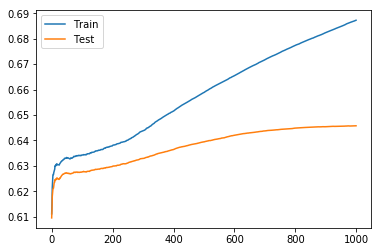

0.645733235855


In [28]:
# sklearn API
# initialize model
max_depth=6
n_estimators=1000
learning_rate=0.01
subsample=0.8
colsample_bytree=0.8
model=LGBMClassifier(max_depth=max_depth,n_estimators=n_estimators,learning_rate=learning_rate,
                     subsample=subsample,colsample_bytree=colsample_bytree,n_jobs=-1,random_state=random_state)

# fit to train & cross validation data
early_stopping_rounds=0.1*n_estimators # generally as a % (e.g. 10%) of training epochs
eval_set=[(X_train_2,y_train_2),(X_val_2,y_val_2)]
eval_metric='auc'
model.fit(X_train_2,y_train_2,early_stopping_rounds=early_stopping_rounds,eval_metric=eval_metric,
          eval_set=eval_set,verbose=True)
results=model.evals_result_

# plot learning curve 
rounds=len(results['training']['auc'])
x_axis=range(0,rounds)
fig,ax=plt.subplots()
ax.plot(x_axis,results['training']['auc'],label='Train')
ax.plot(x_axis,results['valid_1']['auc'],label='Test')
ax.legend()
plt.show()

# predictions
predicted=model.predict_proba(X_val_2)[:,1]

# model performance reports
print(roc_auc_score(y_val_2,predicted))

### (Algorithm Comparison Pipeline)

In [ ]:
# create pipeline for comparing model performances
models=[]
models.append(('xgboost',XGBClassifier()))
models.append(('lightgbm',LGBMClassifier()))

# run cross validation scoring
names=[]
scores=[]
cv=StratifiedShuffleSplit(n_splits=2,random_state=random_state,test_size=test_size)
#cv=StratifiedKFold(n_splits=2,shuffle=True,random_state=random_state)
scoring='roc_auc'
for name,model in models:
    cv_scores=cross_val_score(model,X,y,cv=cv,scoring=scoring,verbose=2,n_jobs=-1)
    scores.append(cv_scores)
    names.append(name)
    print('%s: %f%% (%f%%)'%(name,cv_scores.mean()*100.0,cv_scores.std()*100.0))

## Spot-Check Other Classifiers
### 1) Logistic Regression

In [ ]:
rus=RandomUnderSampler(random_state=random_state)
lr=LogisticRegression(random_state=random_state)
pipe=make_pipeline(rus,lr)
cv=StratifiedKFold(n_splits=10,random_state=random_state)
scores=cross_val_score(estimator=pipe,X=X_no_dups,y=y_no_dups,n_jobs=n_jobs,verbose=2,scoring=scoring)
print(scores.mean())
print(scores.std())

### 2) SVM

In [ ]:
rus=RandomUnderSampler(random_state=random_state)
svc=SVC(random_state=random_state)
pipe=make_pipeline(rus,svc)
cv=StratifiedKFold(n_splits=10,random_state=random_state)
scores=cross_val_score(estimator=pipe,X=X_no_dups,y=y_no_dups,n_jobs=n_jobs,verbose=2,scoring=scoring)
print(scores.mean())
print(scores.std())

## Decomposition
If the above steps give a “good” model, we can go for optimization of hyperparameters and in case it doesn’t we can go for the following steps and improve our model.

## Optimization - Hyperparameter Tuning 

In [ ]:
# set hyperparameter grid
n_estimators=range(1000,3000,1000)
max_depth=range(4,10,2)
learning_rate=[0.0001,0.001,0.01]
subsample=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
colsample_bytree=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
param_grid=dict(max_depth=max_depth)

# initialize grid search
n_splits=2
estimator=XGBClassifier(n_estimators=1000,learning_rate=0.01,subsample=1.0,
                        colsample_bytree=0.5,n_jobs=n_jobs,random_state=random_state)
cv=StratifiedShuffleSplit(n_splits=n_splits,random_state=random_state,test_size=test_size)
model=GridSearchCV(estimator=estimator,param_grid=param_grid,scoring=scoring,cv=cv,n_jobs=-1,verbose=2)
model.fit(X_sel,y)

# show search results
print("Best: %.3f%% using %s\n"%(model.best_score_*100.0,model.best_params_))
for mean,std,param in zip(model.cv_results_['mean_test_score'],model.cv_results_['std_test_score'],
                          model.cv_results_['params']):
    print("%.3f%% (%.3f%%) with: %r"%(mean*100.0,std*100.0,param))

In [ ]:
# visualize search results (scores)
# one parameter case
#plt.errorbar(param_type,means,yerr=stds)

# two parameters case
means=np.array(means).reshape(len(max_depth),len(n_estimators))
for i,value in enumerate(max_depth):
    plt.plot(n_estimators,means[i],label='Depth: '+str(value))
plt.legend()
plt.xlabel(param_name)
plt.ylabel('AUC')
plt.show()

## Ensemble - Stacking

In [ ]:
class Stacking(object):  
    def __init__(self,n_splits,model,estimators):
        self.n_splits=n_splits
        self.model=model
        self.estimators=estimators
        
    def fit_predict(self,X,y,X_test):
        X=np.array(X)
        y=np.array(y)
        X_test=np.array(X_test)
        folds=list(StratifiedKFold(n_splits=self.n_splits,shuffle=True,random_state=2017).split(X,y))
        Y=np.zeros((X.shape[0],len(self.estimators)))
        Y_test=np.zeros((X_test.shape[0],len(self.estimators)))
        
        for i,estimator in enumerate(self.estimators):
            Y_test_i=np.zeros((X_test.shape[0],self.n_splits))
            for j,(train_i,val_i) in enumerate(folds):
                X_train=X[train_i]
                y_train=y[train_i]
                X_val=X[val_i]
                print('Fit %s on fold %d'%(str(estimator).split('(')[0],j+1))
                estimator.fit(X_train,y_train)
                predicted=estimator.predict_proba(X_val)[:,1]                
                Y[val_i,i]=predicted
                Y_test_i[:,j]=estimator.predict_proba(X_test)[:,1]
            Y_test[:,i]=Y_test_i.mean(axis=1)       
        scores=cross_val_score(self.model,Y,y,cv=3,scoring='roc_auc',n_jobs=-1)
        print('Model score: %.5f'%(scores.mean()))
        self.model.fit(Y,y)
        predicted=self.model.predict_proba(Y_test)[:,1]
        return predicted

In [ ]:
# set params
xgb_params_1={
    'max_depth':6,
    'n_estimators':1000,
    'learning_rate':0.01,
    'subsample':0.8,
    'colsample_bytree':0.8
}
lgb_params_1={
    'max_depth':6,
    'n_estimators':1000,
    'learning_rate':0.01,
    'subsample':0.8,
    'colsample_bytree':0.8
}

# set estimators
xgb_model_1=XGBClassifier(**xgb_params_1)
lgb_model_1=LGBMClassifier(**lgb_params_1)

# initialize stacking
model=Stacking(n_splits=3,model=LogisticRegression(),estimators=(lgb_model_1,xgb_model_1))        

# fit to train data and predict on test data 
predicted=model.fit_predict(X_final,y_final,X_test_final)      

## Create Submission File to Kaggle 

In [ ]:
# creat submission file for Kaggle
sub=pd.DataFrame()
sub['id']=test_id
sub['target']=pred
sub.to_csv('ps_submission_1.csv',index=False)